# prophet(+ lightGBM)で予測

In [1]:
from pathlib import Path
import sys

import japanize_matplotlib
from lightgbm import LGBMRegressor, early_stopping
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation
from prophet.serialize import model_to_json, model_from_json
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('../')
from src.forecast_util import calc_scores, get_result_base_dict
from src.dataset import get_forecast_df
from src.constants import (
    Columns,
    ProphetTrainDfColumns,
    ProphetForecastColumns,
    target_column_list,
    scores_file_name,
    submission_file_name,
)
from src.prophet_helpers import get_trainable_df

plt.style.use('ggplot')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
CAP = 100

## データロード

In [3]:
train_df, submit_df, ans_df = get_forecast_df('../data/')

## デフォルトの設定で学習, 予測実施

23:23:42 - cmdstanpy - INFO - Chain [1] start processing
23:23:42 - cmdstanpy - INFO - Chain [1] done processing


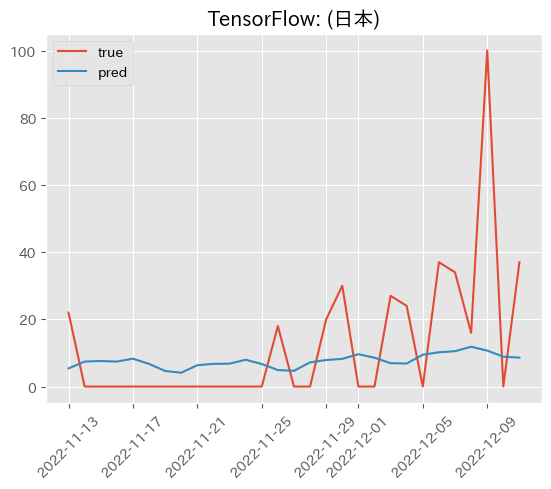

23:23:44 - cmdstanpy - INFO - Chain [1] start processing
23:23:44 - cmdstanpy - INFO - Chain [1] done processing


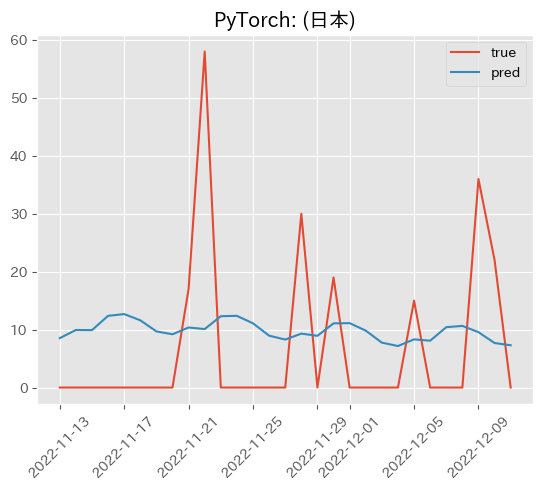

23:23:46 - cmdstanpy - INFO - Chain [1] start processing
23:23:46 - cmdstanpy - INFO - Chain [1] done processing


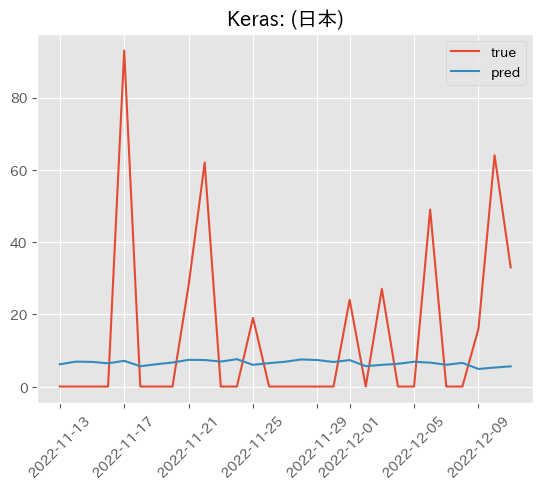

23:23:48 - cmdstanpy - INFO - Chain [1] start processing
23:23:48 - cmdstanpy - INFO - Chain [1] done processing


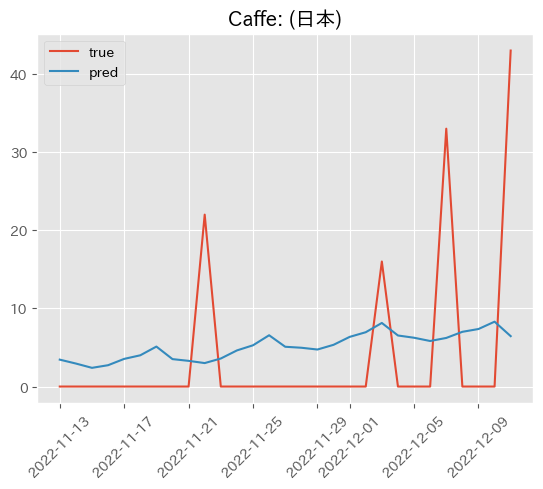

23:23:50 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing


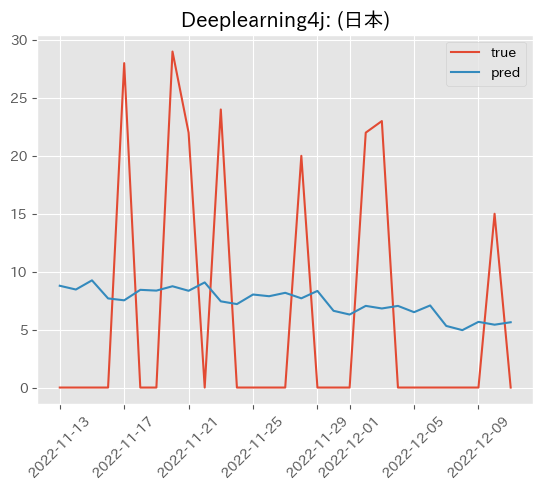

,framework,rmse,mape,mae
0,TensorFlow: (日本),21.012105,4.457899e+09,13.868512
1,PyTorch: (日本),14.388083,7.522613e+09,12.026020
2,Keras: (日本),25.348450,4.329788e+09,16.449981
3,Caffe: (日本),10.456074,4.335065e+09,7.445148
4,Deeplearning4j: (日本),10.492016,5.338726e+09,9.612589


In [4]:
dst_dir = Path('../result/prophet/defaults')
dst_dir.mkdir(parents=True, exist_ok=True)

result = get_result_base_dict()

for i, target_column in enumerate(target_column_list):
    # prophetのインスタンス化
    m = Prophet(growth='logistic', seasonality_mode='multiplicative')
    # 学習
    df = get_trainable_df(train_df, target_column)
    df['cap'] = CAP
    m.fit(df)
    future = m.make_future_dataframe(periods=len(submit_df), include_history=False)
    future['cap'] = CAP
    forecast = m.predict(future)
    # 結果のプロット
    plt.plot(ans_df.set_index(Columns.date)[target_column], label='true')
    plt.plot(forecast.set_index(ProphetForecastColumns.ds)[ProphetForecastColumns.y], label='pred')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(target_column)
    plt.savefig(dst_dir / f'{target_column}_forecast.png')
    plt.show()
    # 評価指標と結果の記録
    y_pred = forecast[ProphetForecastColumns.y].values
    y_true = ans_df[target_column].values
    submit_df[target_column] = y_pred
    score_dict = calc_scores(y_true, y_pred)
    result[i]['rmse'] = score_dict['rmse']
    result[i]['mape'] = score_dict['mape']
    result[i]['mae'] = score_dict['mae']
result = pd.DataFrame(result)
result.to_csv(dst_dir / scores_file_name, index=False)
submit_df.to_csv(dst_dir / submission_file_name, index=False)
result

## ハイパーパラメータチューニングしたProphetでの予測

In [8]:
def get_prophet_objective(target_df):
    def objective(trial):
        # チューニング対象と範囲は、
        # https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning
        # を参考
        params = {
            'changepoint_range' : trial.suggest_float('changepoint_range', 0.8, 0.95),
            'changepoint_prior_scale' : trial.suggest_float('changepoint_prior_scale', 0.001, 0.5),
            'seasonality_prior_scale' : trial.suggest_float('seasonality_prior_scale', 0.01, 10),
            'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10),
            'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
        }
        m = Prophet(
            **params,
            growth='logistic'
        )
        df['cap'] = CAP
        m.fit(target_df)
        df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days', parallel='processes')
        df_p = performance_metrics(df_cv, rolling_window=1)
        return df_p['rmse'].values[0]
    return objective


def get_prophet_optuna_parameter(target_df, n_trials=50):
    study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
    study.optimize(get_prophet_objective(target_df), n_trials=n_trials)
    return study.best_params

[I 2023-01-07 16:04:37,140] A new study created in memory with name: no-name-19b418c5-c72a-4fcf-9252-2b0709616809
16:04:37 - cmdstanpy - INFO - Chain [1] start processing
16:04:38 - cmdstanpy - INFO - Chain [1] done processing
16:04:38 - cmdstanpy - INFO - Chain [1] start processing
16:04:38 - cmdstanpy - INFO - Chain [1] start processing
16:04:38 - cmdstanpy - INFO - Chain [1] start processing
16:04:38 - cmdstanpy - INFO - Chain [1] start processing
16:04:38 - cmdstanpy - INFO - Chain [1] start processing
16:04:38 - cmdstanpy - INFO - Chain [1] start processing
16:04:38 - cmdstanpy - INFO - Chain [1] start processing
16:04:38 - cmdstanpy - INFO - Chain [1] start processing
16:04:38 - cmdstanpy - INFO - Chain [1] done processing
16:04:38 - cmdstanpy - INFO - Chain [1] done processing
16:04:39 - cmdstanpy - INFO - Chain [1] done processing
16:04:39 - cmdstanpy - INFO - Chain [1] done processing
16:04:39 - cmdstanpy - INFO - Chain [1] done processing
16:04:39 - cmdstanpy - INFO - Chain [

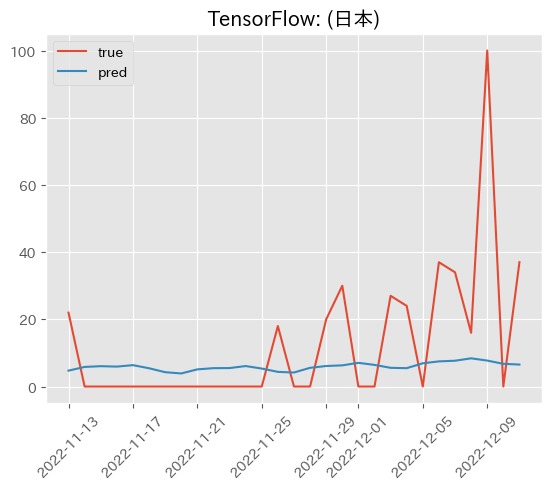

[I 2023-01-07 16:15:14,713] A new study created in memory with name: no-name-1433c342-7f43-4436-87d6-391ceaa61f3c
16:15:14 - cmdstanpy - INFO - Chain [1] start processing
16:15:15 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [

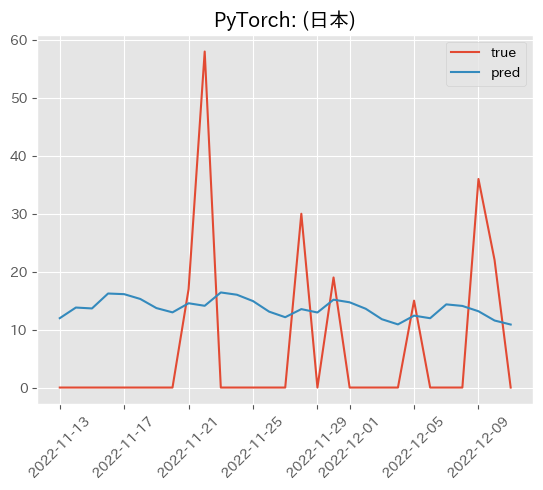

[I 2023-01-07 16:27:24,292] A new study created in memory with name: no-name-32db8f95-29e5-4259-b3e1-9fc197aed552
16:27:24 - cmdstanpy - INFO - Chain [1] start processing
16:27:24 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing
16:27:25 - cmdstanpy - INFO - Chain [

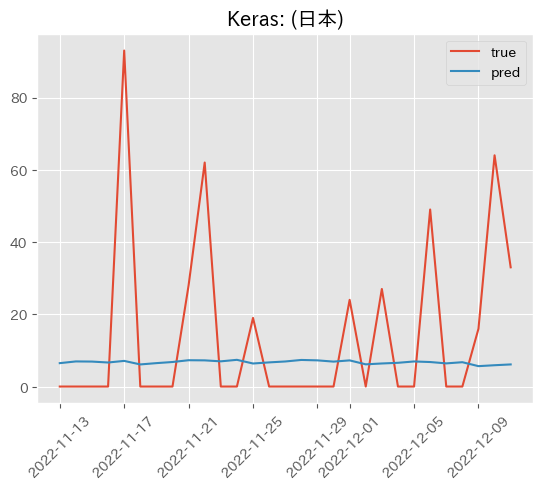

[I 2023-01-07 16:37:10,550] A new study created in memory with name: no-name-7d227095-d988-462a-9bde-7bd7eab11f8f
16:37:10 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] done processing
16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] done processing
16:37:11 - cmdstanpy - INFO - Chain [1] done processing
16:37:11 - cmdstanpy - INFO - Chain [1] done processing
16:37:11 - cmdstanpy - INFO - Chain [1] done processing
16:37:13 - cmdstanpy - INFO - Chain [1] done processing
16:37:13 - cmdstanpy - INFO - Chain [

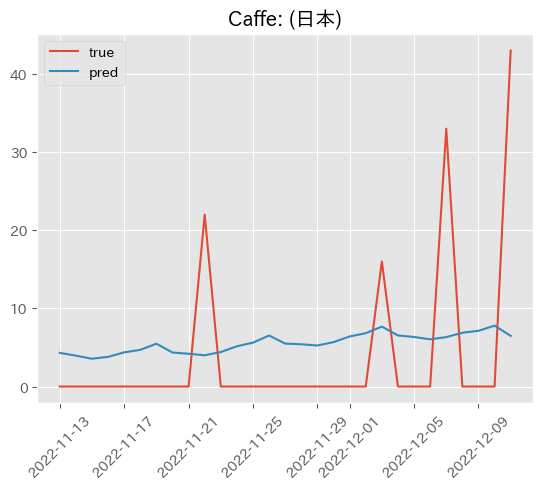

[I 2023-01-07 16:46:30,433] A new study created in memory with name: no-name-ee94e878-de9d-434a-ae80-c4c029676d70
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [

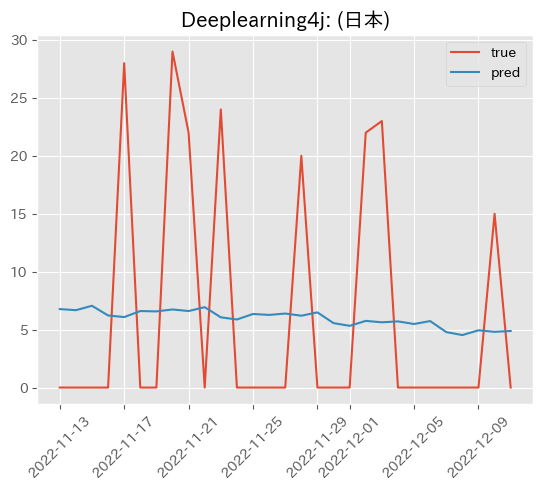

,framework,rmse,mape,mae
0,TensorFlow: (日本),21.735156,3.526543e+09,13.685844
1,PyTorch: (日本),15.591592,1.040057e+10,13.934627
2,Keras: (日本),25.279875,4.437077e+09,16.468957
3,Caffe: (日本),10.526347,4.698700e+09,7.785605
4,Deeplearning4j: (日本),10.425838,4.315642e+09,8.975198


In [9]:
dst_dir = Path('../result/prophet/parameter_tuned/')
dst_dir.mkdir(parents=True, exist_ok=True)
result = get_result_base_dict()
n_trials = 100

for i, target_column in enumerate(target_column_list):
    # パラメータのチューニング
    df = get_trainable_df(train_df, target_column)
    best_params = get_prophet_optuna_parameter(df.copy(), n_trials=n_trials)
    # モデル学習, 保存
    df['cap'] = CAP
    m = Prophet(**best_params, growth='logistic').fit(df)
    with open(str(dst_dir / f'{target_column}_model.json'), 'w') as f:
        f.write(model_to_json(m))
    # 予測
    future = m.make_future_dataframe(periods=len(submit_df), include_history=False)
    future['cap'] = CAP
    forecast = m.predict(future)
    # 結果のプロット
    plt.plot(ans_df.set_index(Columns.date)[target_column], label='true')
    plt.plot(forecast.set_index(ProphetForecastColumns.ds)[ProphetForecastColumns.y], label='pred')
    plt.xticks(rotation=45)
    plt.legend()
    plt.title(target_column)
    plt.savefig(dst_dir / f'{target_column}_forecast.png')
    plt.show()
    # 評価指標と結果の記録
    y_pred = forecast[ProphetForecastColumns.y].values
    y_true = ans_df[target_column].values
    submit_df[target_column] = y_pred
    score_dict = calc_scores(y_true, y_pred)
    result[i]['rmse'] = score_dict['rmse']
    result[i]['mape'] = score_dict['mape']
    result[i]['mae'] = score_dict['mae']
result = pd.DataFrame(result)
result.to_csv(dst_dir / scores_file_name, index=False)
submit_df.to_csv(dst_dir / submission_file_name, index=False)
result

## ハイパーパラメータチューニングを実施したProphet + lightGBM

In [4]:
def cross_val_time_scores(para, df):
    tscv = TimeSeriesSplit()
    for (train_index, test_index) in tscv.split(df):
        X_train, 


def get_lgm_objective(target_df, labels, n_estimators=10000):
    def objective(trial):
        params = {
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 0.1, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 0.1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 2, 30),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.4, 1.0),
            'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
            'min_child_samples': trial.suggest_int('min_child_samples', 0, 50)
        }
        tscv = TimeSeriesSplit()
        rmse_list = []
        for (train_index, valid_index) in tscv.split(target_df):
            X_train, X_valid = target_df.iloc[train_index], target_df.iloc[valid_index]
            y_train, y_valid = labels.iloc[train_index], labels.iloc[valid_index]
            fit_params = {
                'callbacks': [early_stopping(stopping_rounds=10, verbose=0)],
                'eval_metric': 'rmse',
                'eval_set': [(target_df, labels)]
            }
            lgmr = LGBMRegressor(
                **params,
                n_estimators=n_estimators
            )
            lgmr.fit(X_train, y_train, **fit_params)
            preds = lgmr.predict(X_valid)
            rmse = np.sqrt(mean_squared_error(y_valid, preds))
            rmse_list.append(rmse)
        return np.mean(rmse_list)
    return objective


def get_lgm_optuna_parameter(target_df, labels, n_trials=50, n_estimators=10000):
    study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
    study.optimize(get_lgm_objective(target_df, labels, n_estimators), n_trials=n_trials)
    return study.best_params

/usr/local/lib/python3.8/dist-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
[I 2023-01-08 00:30:00,248] A new study created in memory with name: no-name-fdf152c2-1cc8-4820-94f2-eb7630cdd5f8
[I 2023-01-08 00:30:00,583] Trial 0 finished with value: 17.204704048330363 and parameters: {'reg_alpha': 0.004430375245218269, 'reg_lambda': 0.013981961408994055, 'num_leaves': 19, 'colsample_bytree': 0.7269299097981381, 'subsample': 0.6541928796033428, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 0 with value: 17.204704048330363.
[I 2023-01-08 00:30:00,930] Trial 1 finished with value: 16.7659984857753

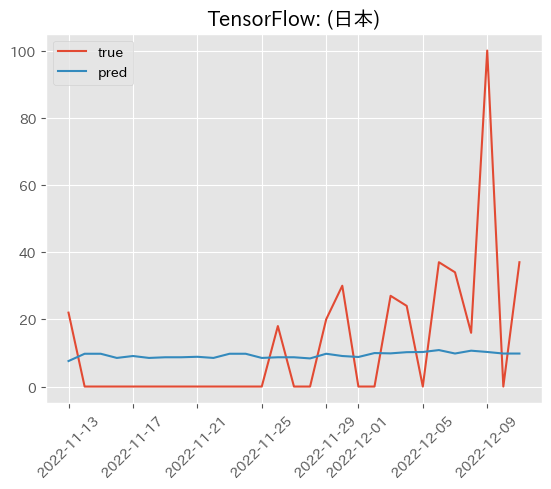

/usr/local/lib/python3.8/dist-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
[I 2023-01-08 00:30:45,415] A new study created in memory with name: no-name-f0f051d3-8d8e-4c08-82ba-e29559c960ae
[I 2023-01-08 00:30:45,691] Trial 0 finished with value: 16.424205593507434 and parameters: {'reg_alpha': 0.004430375245218269, 'reg_lambda': 0.013981961408994055, 'num_leaves': 19, 'colsample_bytree': 0.7269299097981381, 'subsample': 0.6541928796033428, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 0 with value: 16.424205593507434.
[I 2023-01-08 00:30:46,011] Trial 1 finished with value: 16.1051512956252

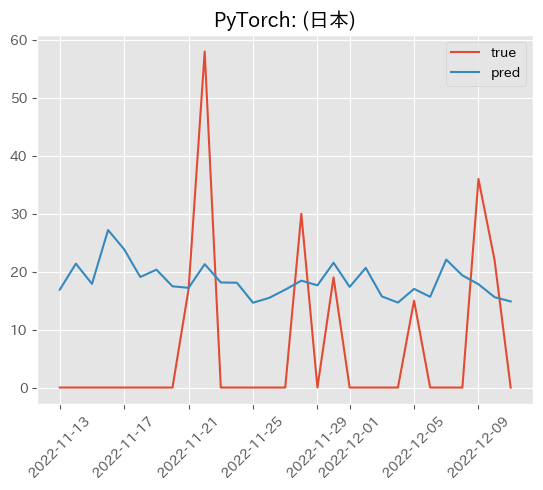

/usr/local/lib/python3.8/dist-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
[I 2023-01-08 00:31:26,437] A new study created in memory with name: no-name-2491441f-2b20-43a5-a982-0bad07ec0526
[I 2023-01-08 00:31:26,975] Trial 0 finished with value: 15.489997733731292 and parameters: {'reg_alpha': 0.004430375245218269, 'reg_lambda': 0.013981961408994055, 'num_leaves': 19, 'colsample_bytree': 0.7269299097981381, 'subsample': 0.6541928796033428, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 0 with value: 15.489997733731292.
[I 2023-01-08 00:31:27,442] Trial 1 finished with value: 15.4749380612748

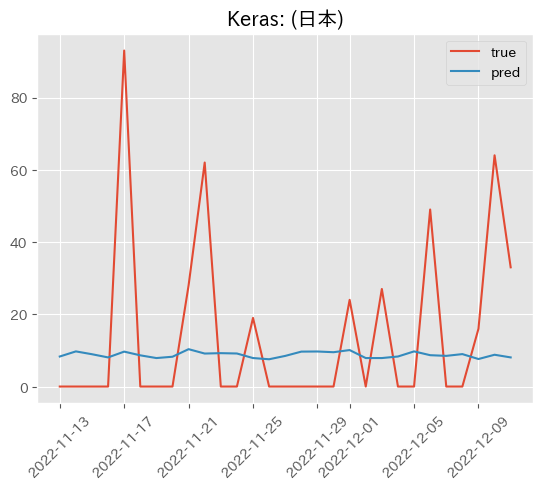

/usr/local/lib/python3.8/dist-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
[I 2023-01-08 00:32:17,247] A new study created in memory with name: no-name-accde68f-85dd-4ae2-90bd-4d9f1d9641a7
[I 2023-01-08 00:32:17,653] Trial 0 finished with value: 14.398730263886463 and parameters: {'reg_alpha': 0.004430375245218269, 'reg_lambda': 0.013981961408994055, 'num_leaves': 19, 'colsample_bytree': 0.7269299097981381, 'subsample': 0.6541928796033428, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 0 with value: 14.398730263886463.
[I 2023-01-08 00:32:18,025] Trial 1 finished with value: 14.1940067237002

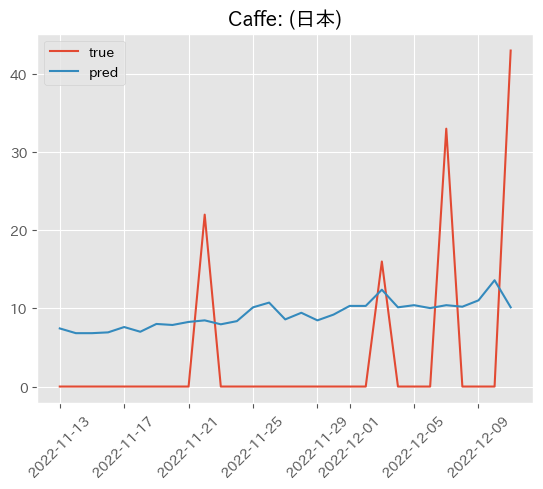

/usr/local/lib/python3.8/dist-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
[I 2023-01-08 00:33:03,954] A new study created in memory with name: no-name-2c92a29b-b6b9-4545-8a16-2db0f9346991
[I 2023-01-08 00:33:04,365] Trial 0 finished with value: 13.46665096674953 and parameters: {'reg_alpha': 0.004430375245218269, 'reg_lambda': 0.013981961408994055, 'num_leaves': 19, 'colsample_bytree': 0.7269299097981381, 'subsample': 0.6541928796033428, 'subsample_freq': 5, 'min_child_samples': 22}. Best is trial 0 with value: 13.46665096674953.
[I 2023-01-08 00:33:04,858] Trial 1 finished with value: 13.45979559635504 

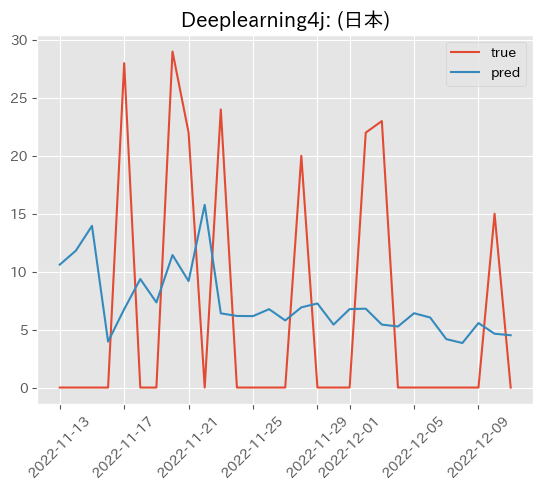

,framework,rmse,mape,mae
0,TensorFlow: (日本),21.099912,5.668929e+09,14.575691
1,PyTorch: (日本),18.140235,1.397892e+10,16.654628
2,Keras: (日本),24.612018,5.741131e+09,17.011489
3,Caffe: (日本),11.584291,7.786650e+09,10.289706
4,Deeplearning4j: (日本),10.789938,5.276094e+09,9.600365


In [5]:
dst_dir = Path('../result/prophet/prohet_and_lightGBM/')
dst_dir.mkdir(parents=True, exist_ok=True)
result = get_result_base_dict()
n_trials = 100

for i, target_column in enumerate(target_column_list):
    with open(f'../result/prophet/parameter_tuned/{target_column}_model.json', 'r') as f:
        m = model_from_json(f.read())

    future = m.make_future_dataframe(periods=len(submit_df), include_history=True)
    future['cap'] = CAP

    forecast = m.predict(future)
    train_forecast = forecast[:len(train_df)]
    test_forecast = forecast[len(train_df):]

    target_df = train_forecast.drop(columns=[ProphetForecastColumns.ds, 'cap'])
    labels = train_df[target_column]
    fit_params = {
        'callbacks': [early_stopping(stopping_rounds=10, verbose=0)],
        'eval_metric': 'rmse',
        'eval_set': [(target_df, labels)]
    }
    best_params = get_lgm_optuna_parameter(target_df, labels, n_trials=n_trials)
    model = LGBMRegressor(**best_params)
    model.fit(target_df, labels, **fit_params)

    test_preds = model.predict(test_forecast.drop(columns=[ProphetForecastColumns.ds, 'cap']))
    test_preds = np.where(test_preds < 0, 0, test_preds)

    plt.plot(ans_df.set_index(Columns.date)[target_column], label='true')
    plt.plot(ans_df[Columns.date], test_preds, label='pred')
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig(dst_dir / f'{target_column}_forecast.png')
    plt.title(target_column)
    plt.show()
    y_pred = test_preds
    y_true = ans_df[target_column].values
    submit_df[target_column] = y_pred
    score_dict = calc_scores(y_true, y_pred)
    result[i]['rmse'] = score_dict['rmse']
    result[i]['mape'] = score_dict['mape']
    result[i]['mae'] = score_dict['mae']
result = pd.DataFrame(result)
result.to_csv(dst_dir / scores_file_name, index=False)
submit_df.to_csv(dst_dir / submission_file_name, index=False)
result